In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/sea.JPG'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Image defogging based on dark channel

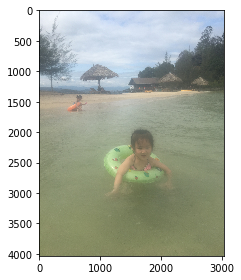

In [4]:
# -*- coding: utf-8 -*-


import cv2
import numpy as np
from skimage import io

def zmMinFilterGray(src, r=7):
    '''''Minimum filter, r is the filter radius'''
    return cv2.erode(src,np.ones((2*r-1,2*r-1)))


def guidedfilter(I, p, r, eps):
    '''''Bootstrap filtering, refer to someone else's code'''
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r,r))
    m_p = cv2.boxFilter(p, -1, (r,r))
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))
    cov_Ip = m_Ip-m_I*m_p

    m_II = cv2.boxFilter(I*I, -1, (r,r))
    var_I = m_II-m_I*m_I

    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I

    m_a = cv2.boxFilter(a, -1, (r,r))
    m_b = cv2.boxFilter(b, -1, (r,r))
    return m_a*I+m_b

def getV1(m, r, eps, w, maxV1):  #Input RGB image, value range [0,1]
    '''''Calculate the atmospheric mask image V1 and illumination value A, V1 = 1-t/A'''
    V1 = np.min(m,2)                                         #Get the dark channel image
    V1 = guidedfilter(V1, zmMinFilterGray(V1,7), r, eps)     #Optimization using guided filtering
    bins = 2000
    ht = np.histogram(V1, bins)                              #Calculate atmospheric illumination A
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax]<=0.999:
            break
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()

    V1 = np.minimum(V1*w, maxV1)                   #Limits the range of values
    return V1,A

def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):
    Y = np.zeros(m.shape)
    V1,A = getV1(m, r, eps, w, maxV1)               #Get mask image and atmospheric illumination
    for k in range(3):
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #Color correction
    Y =  np.clip(Y, 0, 1)
    if bGamma:
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #Gamma correction, which is not performed by default
    return Y

if __name__ == '__main__':
    img1=io.imread('/content/sea.JPG')
    io.imshow(img1)
    m = deHaze(cv2.imread('/content/sea.JPG')/255.0)*255
    cv2.imwrite('defog.jpg', m)
  

Below is a rendering of the image after defogging

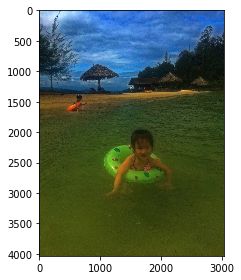

In [5]:
img2=io.imread('./defog.jpg')
io.imshow(img2)